In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import os
from tqdm import tqdm

import tensorflow as tf
from livelossplot  import PlotLossesKerasTF

%matplotlib inline

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset

In [6]:
!pip install patool
import patoolib

patoolib.extract_archive("./Dataset/archive_1.zip", outdir="./Dataset/covidxct")

patool: Extracting ./Dataset/archive_1.zip ...
patool: ... ./Dataset/archive_1.zip extracted to `./Dataset/covidxct'.


'./Dataset/covidxct'

In [3]:
COVID_X_CT_DATASET_PATH = './Dataset/covidxct/2A_images'

In [4]:
label = {0:'normal', 2:'covid'}

train_df = pd.read_csv('./Dataset/covidxct/train_COVIDx_CT-2A.txt', delimiter=' ',  names=['file', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])
test_df = pd.read_csv('./Dataset/covidxct/test_COVIDx_CT-2A.txt', delimiter=' ', names=['file', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])
#val_df = pd.read_csv('../input/covidxct/val_COVIDx_CT-2A.txt', delimiter=' ', names=['file', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])

train_df = train_df[train_df['label'] != 1]
train_df['label'] = train_df['label'].replace(label)
# train_df['label'] = train_df['label'].astype('int')
train_df = train_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)

test_df = test_df[test_df['label'] != 1]
test_df['label'] = test_df['label'].replace(label)
# test_df['label'] = test_df['label'].astype('int')
test_df = test_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)

# val_df = val_df[val_df['label'] != 1]
# train_df['label'] = train_df['label'].replace({2:1})
# val_df = val_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)

# Data Analysis

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118282 entries, 0 to 143777
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   file    118282 non-null  object
 1   label   118282 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [6]:
train_df['label'].value_counts()

covid     82286
normal    35996
Name: label, dtype: int64

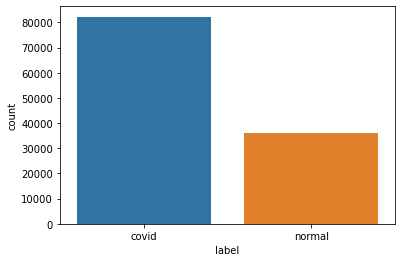

In [7]:
sns.countplot(x='label', data=train_df);

In [8]:
normals = train_df[train_df['label'] == 'normal']
covid = train_df[train_df['label'] == 'covid']
df = pd.concat([normals[:20000], covid[:20000]])
df.shape

(40000, 2)

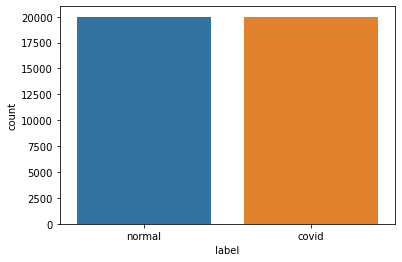

In [9]:
sns.countplot(x='label', data=df);

# Preprocessing

In [10]:
color_mode = "rgb"
number_colour_layers = 3
image_size = (512, 512)   
batch_size = 32
image_shape = image_size + (number_colour_layers,)
print(image_shape)

(512, 512, 3)


In [11]:
# from sklearn.model_selection import train_test_split
# training, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['category'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=(1/255.),validation_split=0.2)


train_datagen = datagen.flow_from_dataframe(df,
                                            directory=COVID_X_CT_DATASET_PATH,
                                            x_col = 'file',
                                            y_col = 'label',
                                            target_size=image_size,
                                            color_mode=color_mode,
                                            batch_size=batch_size,
                                            subset='training',
                                            class_mode='binary'
                                            )

val_datagen = datagen.flow_from_dataframe(df,
                                            directory=COVID_X_CT_DATASET_PATH,
                                            x_col = 'file',
                                            y_col = 'label',
                                            target_size=image_size,
                                            color_mode=color_mode,
                                            batch_size=batch_size,
                                            subset='validation',
                                         class_mode='binary'
                                         )


Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [13]:
print('Number of training samples: ', train_datagen.samples)
print('Number of training classes: ', len(train_datagen.class_indices))
print("classes : {}".format(train_datagen.class_indices))

Number of training samples:  32000
Number of training classes:  2
classes : {'covid': 0, 'normal': 1}


In [14]:
sample = next(train_datagen)
x, y = sample
print('Image info :', x.shape)
print('label info : ', y.shape)

class_mapping = {val:key for key, val in train_datagen.class_indices.items()}
class_mapping

Image info : (32, 512, 512, 3)
label info :  (32,)


{0: 'covid', 1: 'normal'}

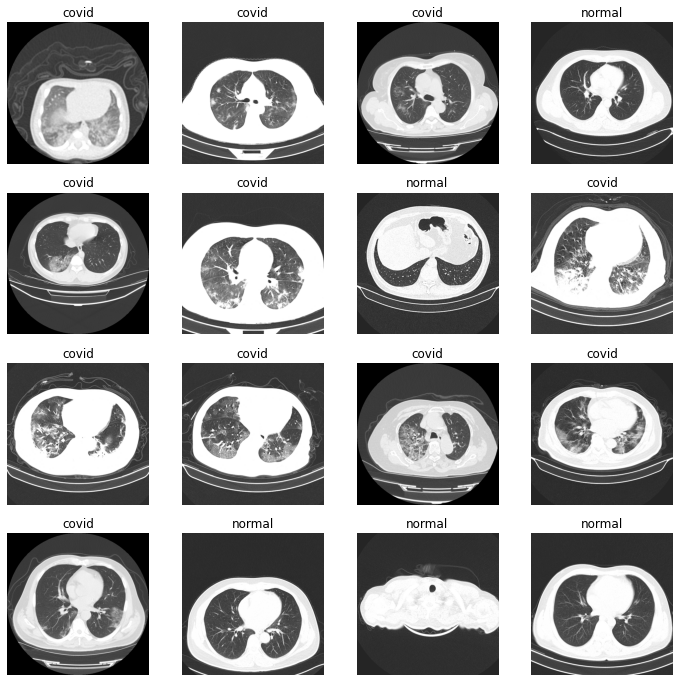

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))
axes = axes.flatten()

for ax, (img ,label) in  zip(axes, zip(x[:16], y[:16])):
    ax.imshow(img)
    ax.set_title(class_mapping[label])
    ax.set_axis_off()

# Model

In [15]:
def get_benchmark_model(input_shape):
    x = tf.keras.layers.Input(shape=input_shape)
    h = tf.keras.layers.Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = tf.keras.layers.Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(h)
    h = tf.keras.layers.Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = tf.keras.layers.Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(h)
    h = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(h)
    h = tf.keras.layers.GlobalAveragePooling2D()(h)
    h = tf.keras.layers.Dense(128, activation='relu')(h)
    h = tf.keras.layers.Dropout(.5)(h)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(h)
    model = tf.keras.Model(inputs=x, outputs=output)
    adam =  tf.keras.optimizers.Adam(lr=0.1)
    model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['acc'])
    return model



def train_model(model, train_datagen, val_datagen, epochs, model_name):
    train_steps_per_epoch = train_datagen.n // train_datagen.batch_size
    val_steps_per_epoch = val_datagen.n // val_datagen.batch_size   
    es = tf.keras.callbacks.EarlyStopping(monitor='val-loss', patience=10)
    reduce = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.2,patience=5, min_lr=0.001 )
    callbacks = [es, PlotLossesKerasTF(), reduce]    
    history = model.fit(train_datagen,
                   steps_per_epoch=train_steps_per_epoch,
                   validation_data=val_datagen,
                   validation_steps=val_steps_per_epoch,
                   epochs = epochs,
                   callbacks=callbacks,
                   verbose=1
                       )
    model.save("./{}.h5".format(model_name))
    return history




def develop_model(pre_trained_model, image_shape):
    temp = pre_trained_model(include_top=False,
                           weights='imagenet', 
                          input_shape=image_shape)       
    for l in temp.layers:
        l.trainable=False
    model = tf.keras.models.Sequential([
          temp , 
            tf.keras.layers.GlobalAvgPool2D(),
            tf.keras.layers.Dense(1024, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation="sigmoid")
               ])
    
    optimizer = tf.keras.optimizers.Adam(0.1)
    model.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['acc'])
    return model

In [16]:
models = []

## Benchmark

In [ ]:
benchmark_model = get_benchmark_model(image_shape)
benchmark_model.summary()

In [ ]:
history = train_model(benchmark_model, train_datagen, validation_datagen, 100, 'benchmark_model')
models.append(benchmark_model)

## Transfer Learning

### 1.ResNet

In [ ]:
resnet_model = develop_model(tf.keras.applications.ResNet101V2, image_shape)
resnet_model.summary()

In [ ]:
history = train_model(resnet_model, train_datagen, val_datagen, 100, 'resnet_model')
models.append(resnet_model)

### 2. VGG 16

In [ ]:
vgg_model= develop_model(tf.keras.applications.vgg16.VGG16, image_shape)
vgg_model.summary()

In [ ]:
history = train_model(vgg_model, train_datagen, val_datagen, 100, 'vgg16')
models.append(vgg_model)

### 3. VGG 19

In [ ]:
vgg19_model = develop_model(tf.keras.applications.vgg19.VGG19, image_shape)
vgg19_model.summary()

In [ ]:
history = train_model(vgg_model, train_datagen, val_datagen, 100, 'vgg19')
models.append(vgg19_model)

### 4. Inception V3

In [17]:

inception_model = develop_model(tf.keras.applications.inception_v3.InceptionV3, image_shape)
inception_model.summary()

87916544/87910968 [==============================] - 21s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
________________________________________________________

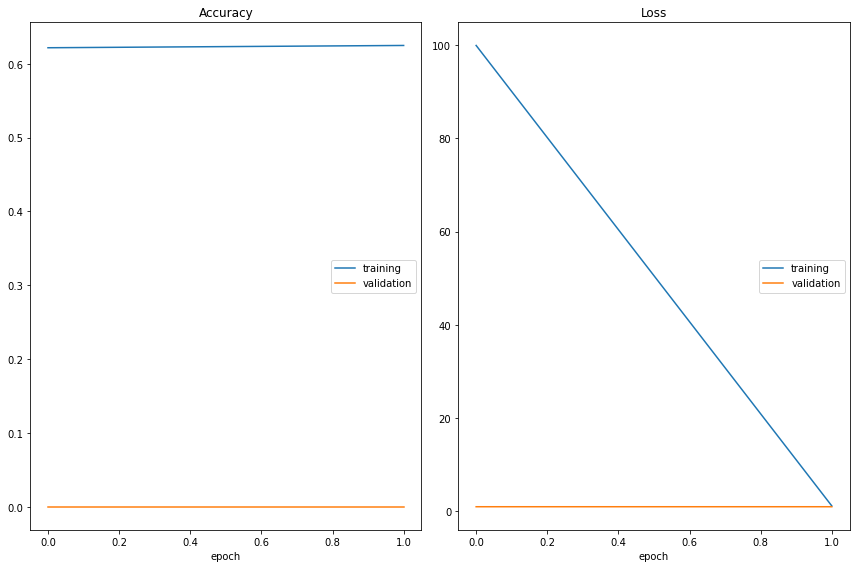

Accuracy
	training         	 (min:    0.622, max:    0.625, cur:    0.625)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    1.152, max:   99.944, cur:    1.152)
	validation       	 (min:    0.983, max:    0.983, cur:    0.983)
Epoch 3/100
 376/1000 [==========>...................] - ETA: 10:33 - loss: 0.6642 - acc: 0.6252

In [ ]:
history = train_model(inception_model,train_datagen, val_datagen, 100, 'inception_v3')
models.append(inception_model)

### 5. DenseNet

In [ ]:
densenet_model = develop_model(tf.keras.applications.densenet.DenseNet201, image_shape)
densenet_model.summary()

In [ ]:
history = train_model(densenet_model, train_datagen, val_datagen, 100)
models.append(densenet_model)

### 6. EfficientNet

In [28]:
efficient_model = develop_model(tf.keras.applications.efficientnet.EfficientNetB5, image_shape)
efficient_model.summary()

115269632/115263384 [==============================] - 24s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 16, 16, 2048)      28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
______________________________________________________

In [29]:
history = train_model(efficient_model, train_datagen, val_datagen, 100, 'efficient_net')
models.append(efficient_model)

Epoch 1/100


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/efficientnetb5/stem_conv/Conv2D (defined at <ipython-input-26-cacd132027f2>:31) ]] [Op:__inference_train_function_34581]

Function call stack:
train_function


# Downloading Model

In [ ]:
os.chdir(r'/kaggle/working')
from IPython.display import FileLink

for model in os.listdir('./'):
    FileLink(model)

# Accuracy Score

In [ ]:
df = ps.DataFrame(columns=['model', 'Accuracy'])

for model in

# Testing Data

In [ ]:
test_datagenerator = ImageDatagenerator(rescale=(1/255.))

test_datagen = test_datagenerator..flow_from_dataframe(test_df,
                                            directory=COVID_X_CT_DATASET_PATH,
                                            x_col = 'file',
                                            y_col = none,
                                            target_size=image_size,
                                            color_mode=color_mode,
                                            class_mode='binary'
                                            )

In [ ]:
y_hat = model.predict(test_datagen)